In [ ]:
!pip install librosa==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 4.7 MB/s 
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pesq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pesq: filename=pesq-0.0.4-cp37-cp37m-linux_x86_64.whl size=214587 sha256=c6ef53954d1bd4668a31dcf84da1f3aec0eab73109d9c25b507150c006c0dde3
  Stored in directory: /root/.cache/pip/wheels/c5/3d/9c/542731f8357f7c82eb6ac2047cc5375f92c9a05b09a715aff6
Successfully built pesq


In [ ]:
pip install memspectrum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import numpy as np
from pydub import AudioSegment
import os
from scipy.io.wavfile import write

from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate

from math import cos

from memspectrum import MESA

import gdown

In [ ]:
urls = {'alignment_signal_02__05_15.mp3':
        'https://drive.google.com/uc?id=1piUSPUTTJXLwPJ15gsEeAsqMjqHm3nQm',
        
        'artificial_signal_06__05_15.mp3':
        'https://drive.google.com/uc?id=1TaLPDFHHVT79zSTAXKTHIHX3R_V3RXZ9',

        'orchestra_68__01_11.mp3':
        'https://drive.google.com/uc?id=1P_BSKrOLKdMMrTqF2GajLa7V-av_YrM-',

        'pop_music_70__01_11.mp3':
        'https://drive.google.com/uc?id=1dIJ2FLGNURT2lFhD7ZeiZnxXJj1ahxHV',

        'single_instrument_08__14_24.mp3':
        'https://drive.google.com/uc?id=1XvjouJL-Yx6lZzwkOcseB3dtfXT0f-OW',

        'solo_instrument_55__01_11.mp3':
        'https://drive.google.com/uc?id=1wEGtoAe9gZBCLZpONZT1v-rETKvaC83a',

        'speech_51__08_18.mp3':
        'https://drive.google.com/uc?id=1bsX9KYLDGQOxE10six2bYkbX4fQ1Txm8',

        'vocal_48__01_11.mp3':
        'https://drive.google.com/uc?id=11FYsLvJD4Md0ozWso7TBxvFIAoufeeZu',

        'vocal_orchestra_64__02_12.mp3':
        'https://drive.google.com/uc?id=1QnT_heq-8a44gtg1TKtFfkgmot5CMH6K'}


for file_name, url in urls.items():
  gdown.download(url, file_name, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1piUSPUTTJXLwPJ15gsEeAsqMjqHm3nQm
To: /content/alignment_signal_02__05_15.mp3
100%|██████████| 297k/297k [00:00<00:00, 48.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TaLPDFHHVT79zSTAXKTHIHX3R_V3RXZ9
To: /content/artificial_signal_06__05_15.mp3
100%|██████████| 85.9k/85.9k [00:00<00:00, 57.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_BSKrOLKdMMrTqF2GajLa7V-av_YrM-
To: /content/orchestra_68__01_11.mp3
100%|██████████| 302k/302k [00:00<00:00, 72.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dIJ2FLGNURT2lFhD7ZeiZnxXJj1ahxHV
To: /content/pop_music_70__01_11.mp3
100%|██████████| 161k/161k [00:00<00:00, 17.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XvjouJL-Yx6lZzwkOcseB3dtfXT0f-OW
To: /content/single_instrument_08__14_24.mp3
100%|██████████| 306k/306k [00:00<00:00, 73.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wEGtoAe9gZBCLZpONZT1v-rETKvaC83a
To: /content/solo_i

In [ ]:
def get_channels(path):
   sound = AudioSegment.from_file(path, format="mp3")
   return sound.split_to_mono()

def get_sample(sound, chunk_size, loss_percentage=0.25): 
  peak_amplitude = sound.max
  loudness = sound.dBFS
  channels_cnt = sound.channels
  raw = np.array(sound.get_array_of_samples())

  frame_r = sound.frame_rate
  audio_info = np.array([peak_amplitude, channels_cnt, sound.frame_rate, 
              chunk_size, sound.frame_count()/ sound.frame_rate], dtype=object)
  
  cur_loss = 0

  package = []
  size = chunk_size * channels_cnt
  cnt = 0

  while (cnt + 1) * size < len(raw):
    cur_loss += loss_percentage
    if abs(cur_loss - 1) < 10**(-15):
      chunk = np.array([-32768 for _ in range(size)], dtype="int16")
      cur_loss = 0
    else :
      chunk = np.array(raw[(cnt * size) : ((cnt + 1)*size)], dtype='int16')


    package.append(chunk)
    cnt += 1

  package = np.array(package)
  audio = np.array([package, audio_info])
  return audio

In [ ]:
def is_broken(chunk):
  return np.array_equal(chunk, np.array([-32768 for _ in range(chunk.shape[0])], dtype="int16"))

In [ ]:
def get_audio(audio_array, broken_audio_path):
  cp_audio_array = deepcopy(audio_array)
  broken_chunk = np.array([-32768 for _ in range(cp_audio_array[1][3] * cp_audio_array[1][1])], dtype="int16")
  for i in range(len(cp_audio_array[0])):
    if np.array_equal(cp_audio_array[0][i], broken_chunk):
      cp_audio_array[0][i] = np.zeros(cp_audio_array[1][3] * cp_audio_array[1][1], dtype="int16")
  song = AudioSegment(cp_audio_array[0].tobytes(), frame_rate=cp_audio_array[1][2], sample_width=2, channels=cp_audio_array[1][1])
  song.export(broken_audio_path, format=broken_audio_path.split(".")[-1], bitrate="320k")

In [ ]:
def get_file_names(audio_path, num_samples, loss_percentage):
  paths = []

  path = audio_path.split("/")
  file_name = path.pop()

  path = "/".join(path) + "/"

  if loss_percentage < 10**(-15):
    paths.append(path + "{:.2f}".format(loss_percentage) + "___all_channels___" + file_name)

  for idx in range(1, num_samples + 1):
    paths.append(path + "{:.2f}".format(loss_percentage) + "___channel_" + str(idx) + "___" + file_name)

  return paths

def get_channel_samples(audio_path, chunk_size, loss_percentage, return_file_names = True):
  all_channels_sound = AudioSegment.from_file(audio_path, format="mp3")
  channels = get_channels(audio_path)

  channel_samples = []
  if loss_percentage < 10**(-15):
    channel_samples.append(get_sample(all_channels_sound, chunk_size, loss_percentage))
    file_names = get_file_names(audio_path, len(channels), loss_percentage)
  else:
    file_names = get_file_names(audio_path, len(channels), loss_percentage)

  for channel in channels:
    channel_samples.append(get_sample(channel, chunk_size, loss_percentage))

  for idx, sample in enumerate(channel_samples):
    get_audio(channel_samples[idx], file_names[idx])
  
  if return_file_names:
    return channel_samples, file_names
  return channel_samples


In [ ]:
def plot_channels(num_channels, channel_samples, title):
  fig, ax = plt.subplots(1, num_channels)

  plots_y = []

  size_y = channel_samples[0][0].shape[0]*channel_samples[0][0].shape[1]
  for i in range(num_channels):
    plots_y.append(channel_samples[i][0].copy())
    plots_y[i].resize(size_y)

  time = np.array(range(plots_y[0].shape[0])) / channel_samples[0][1][2]

  if num_channels == 1:
    plt.plot(time, plots_y[0])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

  else:
    for idx, x in enumerate(ax):
      x.plot(time, plots_y[idx])
      x.set_xlabel("Time")
      x.set_ylabel("Amplitude")
      x.set_title(f"Channel {str(idx + 1)} {title}")

  plt.tight_layout()

In [ ]:
def  burg_AR(m,  x):
    """
    Based on Collomb's C++ code, pp. 10-11
    Burgs Method, algorithm and recursion
      m - number of lags in autoregressive model.
      x  - data vector to approximate.
    """
    N = len(x)-1
    coeffs = np.zeros(m)
    
    # initialize Ak
    Ak    = np.zeros(m+1)
    Ak[0] = 1.0 
    # initialize f and b.
    f  = x.copy()
    b = x.copy()
    # Initialize Dk
    Dk = 0.0
    for j in range(N+1):
        Dk += 2.0 * f[j] ** 2 
    Dk -= (f[0] ** 2) + (b[ N ] ** 2) 

    #Burg recursion
    for k in range(m):
        # compute mu
        mu = 0.0
        for n in range(N-k):
            mu += f[ n + k + 1 ] * b[ n ]
        try:
          mu *= -2.0 / Dk
        except:
          mu = 0
        # update Ak
        maxn = int((k+1)/2) + 1 # rounds down 
        # print("test")
        # print(maxn)
        for n in range(maxn):
            t1 = Ak[ n ] + mu * Ak[ k + 1 - n ]
            t2 = Ak[ k + 1 - n ] + mu * Ak[ n ]
            Ak[ n ] = t1
            Ak[ k + 1 - n ] = t2
        #update f and b
        for n in range(N-k):
            t1 = f[ n + k + 1 ] + mu * b[n]
            t2 = b[ n ] + mu * f[ n + k + 1]
            f[ n + k + 1 ] = t1
            b[ n ] = t2
            
        #update Dk
        Dk = ( 1.0 - mu ** 2) * Dk - (f[ k + 1 ] ** 2) - (b[ N - k - 1 ] ** 2)
    
    # assign coefficients.
    coeffs[:] = Ak[1:]
    
    return coeffs

########### OR ###########

#coeffs, _, _ = spectrum.arburg(func, order)



In [ ]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    if leftSpan == 0:
      return 0
    
    valueScaled = float(value - leftMin) / float(leftSpan)

    return rightMin + (valueScaled * rightSpan)

In [ ]:
def Burg_method_extrapolation_with_lib(original_part, loss_percentage, 
                                       num_of_simulations = 1, speed = "Fast"):
  data = np.copy(original_part)

  min_data = np.min(data)
  max_data = np.max(data)

  data = [translate(i, min_data, max_data, -1, 1) for i in data]

  m = MESA()
  m.solve(data, method = speed)
  forecast = m.forecast(data, 
                        length = int(loss_percentage * original_part.shape[0] / (1 - loss_percentage)), 
                        number_of_simulations = num_of_simulations, include_data = False)
  median = np.median(forecast, axis = 0)

  median = [translate(i, -1, 1, min_data, max_data) for i in median]

  return median

def Burg_method_extrapolation_with_lib_FAST(original_part, loss_percentage):
  return Burg_method_extrapolation_with_lib(original_part, loss_percentage, num_of_simulations = 100, speed = "Fast")

def Burg_method_extrapolation_with_lib_standard(original_part, loss_percentage):
  return Burg_method_extrapolation_with_lib(original_part, loss_percentage, num_of_simulations = 100, speed = "standard")

In [ ]:
def Burg_method_extrapolation_without_lib(original_part, loss_percentage):

  ranges = [[-1, 1], [0, 1], [-1, 0]]

  for new_range in ranges:
    data = np.copy(original_part)

    min_data = np.min(data)
    max_data = np.max(data)

    data = [translate(i, min_data, max_data, new_range[0], new_range[1]) for i in data]

    coeffs = burg_AR(original_part.shape[0] - 1, data)

    extrapolated = [0 for _ in range(int(loss_percentage * original_part.shape[0] / (1 - loss_percentage)))]

    data = data + extrapolated

    m = len(coeffs)
    for i in range(m + 1,  len(data)):
        for j in range(m):
            data[ i ] -= coeffs[ j ] * data[i - 1 - j]


    extrapolated = data[-int(loss_percentage * original_part.shape[0] / (1 - loss_percentage)):]
    extrapolated = [translate(i, new_range[0], new_range[1], min_data, max_data) for i in extrapolated]

    min_extrapolated = np.min(extrapolated)
    max_extrapolated = np.max(extrapolated)

    if (min_extrapolated < 2 * min_data or max_extrapolated > 2 * max_data):
      if (new_range == [-1, 0]):
        return [0 for _ in extrapolated]
      continue

    return extrapolated


In [ ]:
def extrapolate(original_sound, lossy_sound, loss_percentage, method):

  chunk_size = original_sound.shape[1]
  one_extrapolation_block_size = chunk_size / loss_percentage

  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])

  broken_chunks = []
  
  for idx, chunk in enumerate(lossy_sound):
    if is_broken(chunk):
      broken_chunks.append(idx)
  
  extrapolated_chunks = dict()

  for chunk_idx in broken_chunks:
    right = int(chunk_idx * chunk_size)
    left = int((chunk_idx + 1) * chunk_size - one_extrapolation_block_size)
    try:
      extrapolated_chunks[right] = method(original_sound_1d[left:right], 
                                              loss_percentage)
    except:
      extrapolated_chunks[right] = [0 for _ in range(chunk_size)]

  return extrapolated_chunks


In [ ]:
def plot_extrapolation(original_sound, extrapolated_chunks, title, MSE_norm, MSE_fft):
  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])
  sample_nums = np.arange(0, original_sound_1d.shape[0])

  plt.plot(sample_nums, original_sound_1d, color = 'k', label = 'Initial signal')

  chunks_sample_nums = []
  chunks_extrapolated = []
  chunks_original = []
  for k, v in extrapolated_chunks.items():
    chunks_sample_nums.extend(np.arange(k, k + len(v)))
    chunks_extrapolated.extend(v)
    chunks_original.extend(original_sound_1d[k:k+len(v)])
  plt.plot(chunks_sample_nums, chunks_original, color = 'b', label = 'Lost signal')
  plt.plot(chunks_sample_nums, chunks_extrapolated, color = 'r', label = 'Restored signal')
    
  plt.legend(loc='upper left')
  plt.title(f"{title}, MSE_norm = {MSE_norm}, MSE_fft = {MSE_fft}")

  plt.show()

In [ ]:
def get_mse(reference_chunk, changed_chunk):
  audio1 = reference_chunk
  audio2 = changed_chunk

  min_data1 = np.min(audio1)
  max_data1 = np.max(audio1)

  audio1 = [translate(i, min_data1, max_data1, -1, 1) for i in audio1]

  min_data2 = np.min(audio2)
  max_data2 = np.max(audio2)

  audio2 = [translate(i, min_data1, max_data2, -1, 1) for i in audio2]

  ref = np.abs(np.fft.fft(audio1))
  changed = np.abs(np.fft.fft(audio2))
  MSE_norm = []
  MSE_fft = []
  for i in range(len(audio1)):
    MSE_norm.append((audio1[i] - audio2[i])**2)
    MSE_fft.append((ref[i] - changed[i])**2)
  MSE_norm =sum(MSE_norm) / len(MSE_norm)
  MSE_fft =sum(MSE_fft) / len(MSE_fft)

  return MSE_norm.real, MSE_fft.real

# def MSE(initial_chunk, extrapolated_chunk):
#   normalized_initial_chunk = [translate(i, np.min(initial_chunk), np.max(initial_chunk), -1, 1) for i in initial_chunk]
#   normalized_extrapolated_chunk = [translate(i, np.min(extrapolated_chunk), np.max(extrapolated_chunk), -1, 1) for i in extrapolated_chunk]
#   return np.square(np.subtract(normalized_initial_chunk, normalized_extrapolated_chunk)).mean()

def count_MSE_extrapolation(original_sound, extrapolated_chunks):
  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])

  counter = 0
  sum_MSE_norm = 0
  sum_MSE_fft = 0

  for k, v in extrapolated_chunks.items():
    sum_MSE_norm, sum_MSE_fft = get_mse(original_sound_1d[k:k + len(v)], v)
    counter += 1
    # print(MSE(original_sound_1d[k:k + len(v)], v))

  return sum_MSE_norm / counter, sum_MSE_fft / counter


###################
#idea for table

#chunk size
#64   128   256

#loss perc.
#0.01   0.05   0.1   0.25

#9 types of sound: alignment signal, 
#artificial signal, single instrument, 
#vocal, speech, solo instrument, vocal and orchestra, 
#orchestra, pop music

#1 sound of each type - 10 sec

# 6 methods

### results ###
# 3 * 4 * 9 * 6 = 648 experiments

In [ ]:
def save_extrapolated_sound(original_sound, lossy_sound, extrapolated_chunks, file_name):
  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])

  extrapolated_sound_1d = np.copy(lossy_sound)
  extrapolated_sound_1d.resize(extrapolated_sound_1d.shape[0]*extrapolated_sound_1d.shape[1])

  lossy_sound_1d = np.copy(lossy_sound)
  lossy_sound_1d.resize(lossy_sound_1d.shape[0]*lossy_sound_1d.shape[1])

  for k, v in extrapolated_chunks.items():
    extrapolated_sound_1d[k:k + len(v)] = v
    lossy_sound_1d[k:k + len(v)] = np.array([0 for _ in range(len(v))])
  
  settings_original = np.array([np.max(np.abs(original_sound_1d)), 1, 44100, 
              len(original_sound[0]), original_sound_1d.shape[0] / 44100], dtype=object)
  settings_extrapolated = np.array([np.max(np.abs(extrapolated_sound_1d)), 1, 44100, 
              len(original_sound[0]), original_sound_1d.shape[0] / 44100], dtype=object)
  settings_lossy = np.array([np.max(np.abs(lossy_sound_1d)), 1, 44100, 
              len(original_sound[0]), original_sound_1d.shape[0] / 44100], dtype=object)

  get_audio([original_sound_1d, settings_original], "/content/sample_data/original_" + file_name + ".mp3")
  get_audio([extrapolated_sound_1d, settings_extrapolated], "/content/sample_data/extrapolated_" + file_name + ".mp3")
  get_audio([extrapolated_sound_1d, settings_extrapolated], "/content/sample_data/lossy_" + file_name + ".mp3")


In [ ]:
# num_channel should start from 1
def preparation(audio_path, num_channel, loss_percentage, chunk_size):
  channel_samples_0, file_names_0 = get_channel_samples(audio_path, chunk_size, 0)
  channel_samples_10, file_names_10 = get_channel_samples(audio_path, chunk_size, loss_percentage)

  original_sound = np.copy(channel_samples_0[num_channel][0])
  lossy_sound = np.copy(channel_samples_10[num_channel - 1][0])

  return original_sound, lossy_sound

def test_k(val1, val2, loss_percentage, original_sound, lossy_sound, 
         method, title, file_name, num_of_simulations = 1, speed = "Fast"):
  extrapolated_chunks = extrapolate(original_sound[val1:val2], lossy_sound[val1:val2], loss_percentage, method,
                                    num_of_simulations, speed)
  MSE_value = count_MSE_extrapolation(original_sound[val1:val2], extrapolated_chunks)

  plot_extrapolation(original_sound[val1:val2], extrapolated_chunks, title, MSE_value)
  save_extrapolated_sound(original_sound[val1:val2], lossy_sound[val1:val2], extrapolated_chunks, file_name)


Interpolation block


In [ ]:
def interpolate_chunks(audio_array, broken_chunk_idx, lhs, rhs, method, initial_array, visualize=False):
  chunk_size = audio_array[1][3] * audio_array[1][1]
  x = np.concatenate([np.arange(0, lhs * chunk_size, 1), np.arange((lhs + 1) * chunk_size, (rhs + lhs + 1) * chunk_size, 1)])
  y = np.concatenate([audio_array[0][broken_chunk_idx - lhs : broken_chunk_idx].flatten(), audio_array[0][broken_chunk_idx + 1 : broken_chunk_idx + rhs + 1].flatten()])
  x_new = np.arange( lhs * chunk_size, (lhs + 1) * chunk_size, 1)


  if method == "trigonometric":
    f = y
    F = np.fft.fft(f);            
    F = np.fft.fftshift(F);                     
    F = np.concatenate([np.zeros(chunk_size // 2),F,np.zeros(chunk_size // 2)]);     
    F = np.fft.ifftshift(F);               
    fi = np.fft.ifft(F) 
    restored_chunk = fi[lhs * chunk_size : (lhs + 1) * chunk_size]
  else:
    f = interpolate.interp1d(x, y, kind=method)
    restored_chunk = np.array(f(x_new), dtype="int16")
  initial_data = initial_array[0][broken_chunk_idx]
  MSE = get_mse(initial_array[0][broken_chunk_idx], restored_chunk)
  if visualize:

    plt.plot(np.arange(0, (lhs + rhs + 1) * chunk_size), initial_array[0][broken_chunk_idx - lhs : broken_chunk_idx + rhs + 1].flatten(), color = 'k', label = 'Initial signal')
    plt.plot(x_new, restored_chunk, color = 'r', label = 'Reconstructed signal')
    plt.plot(x_new, initial_array[0][broken_chunk_idx], color = 'b', label = 'Lost signal')
    plt.legend(loc='upper left')

    

    plt.title(f"Lost chunk {broken_chunk_idx + 1}, MSE = {MSE[0].real}")
    plt.show()

  return restored_chunk, MSE[0], MSE[1]

In [ ]:
from random import choice

def restore_audio(audio_array, initial_array, method, num_plots):
  cp_audio_array = deepcopy(audio_array)
  left_side_num_chunks, right_side_num_chunks = 0, 0
  broken_chunk_idx = 0
  MSE_array = []
  MSE_fft_array = []

  for i in range(len(cp_audio_array[0])):
    if is_broken(cp_audio_array[0][i]):
      # print("!!!!", i)
      if not broken_chunk_idx:
        if i == 0:
          left_side_num_chunks = 1
        else:
          left_side_num_chunks = i - left_side_num_chunks
        broken_chunk_idx = i
        continue
      right_side_num_chunks = i - broken_chunk_idx - 1
      visualize = False
      # ------ interpolate -------
      if num_plots > 0:
        visualize = choice([True, False])
        if visualize:
          num_plots -= 1

      restored_chunk, MSE, MSE_fft = interpolate_chunks(cp_audio_array, broken_chunk_idx, max(left_side_num_chunks, 1), max(right_side_num_chunks, 1), method, initial_array, visualize)
      visualize = False
      MSE_array.append(MSE)
      MSE_fft_array.append(MSE_fft)
      cp_audio_array[0][broken_chunk_idx] = restored_chunk
      broken_chunk_idx = i
      left_side_num_chunks = right_side_num_chunks
  if is_broken(cp_audio_array[0][-1]):
    cp_audio_array[0][-1] = np.zeros(audio_array[1][3] * audio_array[1][1])


  return cp_audio_array, MSE_array, MSE_fft_array

In [ ]:
def get_audio_mse(channel_samples_0, channel_samples_50, method, num_plots):
  audio_channels, MSE_channels = [], []
  for i in range(len(channel_samples_50)):
    restored, MSE_array, MSE_fft_array = restore_audio(channel_samples_50[i], channel_samples_0[i + 1], method, num_plots)
    audio_channels.append(restored)
    MSE_channels.append((MSE_array, MSE_fft_array))
  return audio_channels, MSE_channels

def test(audio_path, chunk_size, loss_percentage=0.25, num_plots=0):
  channel_samples_orig, file_names_orig = get_channel_samples(audio_path, chunk_size, 0)
  channel_samples_loss, file_names_loss = get_channel_samples(audio_path, chunk_size, loss_percentage)
  # interpolations = {"trigonometric" : [], "linear": [], "quadratic": []}
  # for method in interpolations:
  #   audio_channels, MSE_channels = get_audio_mse(channel_samples_orig, channel_samples_loss, method, num_plots)
  #   interpolations[method] = MSE_channels
  #   MSE_all_channels_mean_norm, MSE_all_channels_mean_fft = 0, 0
  #   for i in range(len(audio_channels)):
  #     mse_norm_mean, mse_fft_mean = np.array(MSE_channels[i][0]).mean(), np.array(MSE_channels[i][1]).mean()
  #     MSE_all_channels_mean_norm += mse_norm_mean
  #     MSE_all_channels_mean_fft += mse_fft_mean
  #     print(f"channel = {i + 1}", method, loss_percentage, mse_norm_mean, mse_fft_mean)
  #   MSE_all_channels_mean_norm /= len(audio_channels)
  #   MSE_all_channels_mean_fft /= len(audio_channels)
  #   print(f"channel = combined", method, loss_percentage, MSE_all_channels_mean_norm, MSE_all_channels_mean_fft)


  extrapolations_methods = {"our Burg's method": Burg_method_extrapolation_without_lib, 
                            "fast Burg's method from lib": Burg_method_extrapolation_with_lib_FAST,
                            "standard Burg's method from lib": Burg_method_extrapolation_with_lib_standard}
  #extrapolations = {"our Burg's method" : [], "fast Burg's method from lib" : [],"standard Burg's method from lib" : []}
  extrapolations = {"our Burg's method" : []}

  for method in extrapolations.keys():
    MSE_channels = []
    for channel_idx, _ in enumerate(channel_samples_loss):
      original_sound = channel_samples_orig[channel_idx + 1][0]
      lossy_sound = channel_samples_loss[channel_idx][0]

      extrapolated_chunks = extrapolate(original_sound, lossy_sound, loss_percentage, extrapolations_methods[method])

      MSE_channels.append(count_MSE_extrapolation(original_sound, extrapolated_chunks))
      print(f"channel {channel_idx + 1}, {method}, MSE_norm = {MSE_channels[-1][0]}, MSE_fft = {MSE_channels[-1][1]}")
      if (num_plots > 0):
        plot_extrapolation(original_sound, extrapolated_chunks, method, MSE_channels[-1][0], MSE_channels[-1][1])
    MSE_norm = MSE_fft = 0
    for channel in MSE_channels:
      MSE_norm += channel[0]
      MSE_fft += channel[1]
    MSE_norm /= len(MSE_channels)
    MSE_fft /= len(MSE_channels)
    print(f"all channels, {method}, MSE_norm = {MSE_norm}, MSE_fft = {MSE_fft}")

  
def test_visualize(audio_path, chunk_size, method, num_plots, loss_percentage=0.25):
  channel_samples_0, file_names_0 = get_channel_samples(audio_path, chunk_size, 0)
  channel_samples_50, file_names_50 = get_channel_samples(audio_path, chunk_size, loss_percentage)
  audio_channels, MSE_channels = get_audio_mse(channel_samples_0, channel_samples_50, method, num_plots)
  plot_channels(len(audio_channels), audio_channels, "Restored")
  plot_channels(len(audio_channels), channel_samples_0, "Initial")
  get_audio(audio_channels[0], "/content/sample_data/restored.mp3")

  for i in range(len(MSE_channels)):
    fig = plt.figure(i)
    plt.plot(np.arange(1, len(MSE_channels[i]) + 1, 1), MSE_channels[i])
    plt.title(f"Mean Squared Errors of the restored audio. Mean MSE = {np.array(MSE_channels[i]).mean()}")
    plt.show()




In [ ]:
# test("/content/single_instrument_08__14_24.mp3", 64)

2.0 3.0


In [ ]:
def get_final_test_data(audio_path):
  chunk_sizes = [64, 128, 256]
  losses = [0.1, 0.25]
  for chunk in chunk_sizes:
    for loss in losses:
      print(f"\n\nCHUNK SIZE = {chunk}, LOSS = {loss}, FILE = {audio_path}")
      test(audio_path, chunk, loss)
      print()

In [ ]:
for audio in urls:
  get_final_test_data(f"/content/{audio}")
  print("\n\n-----------------------------------------------------------------------------\n\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


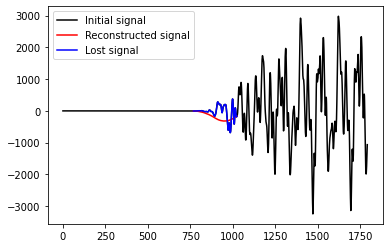

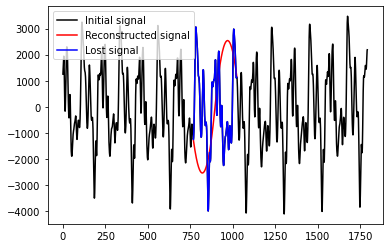

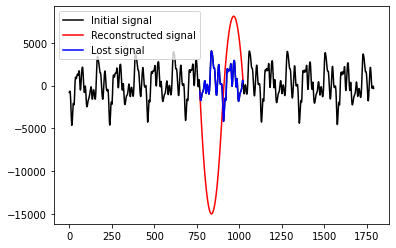

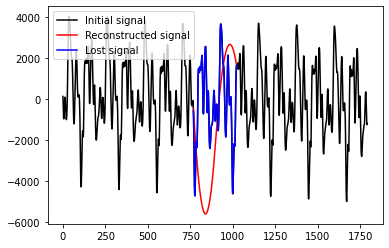

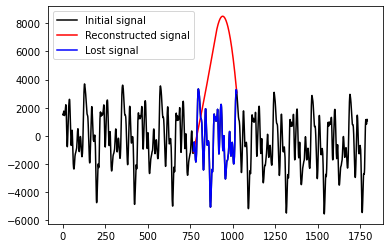

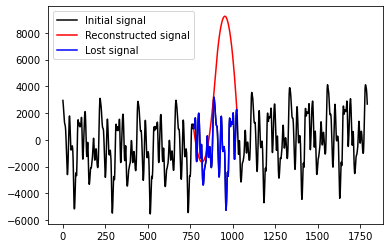

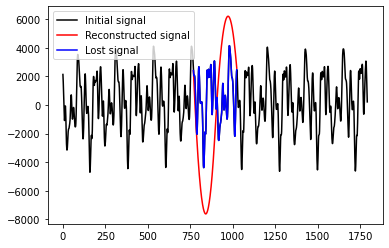

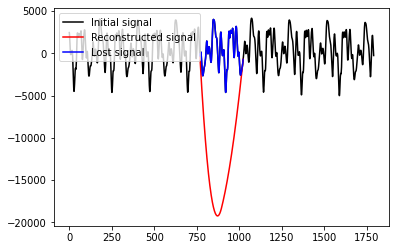

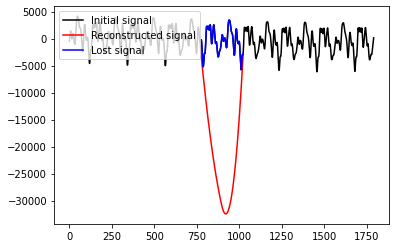

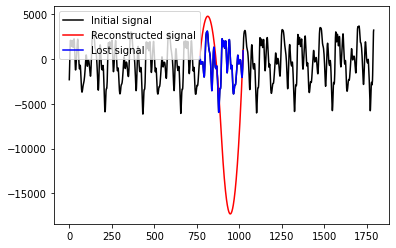

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in short_scalars
  


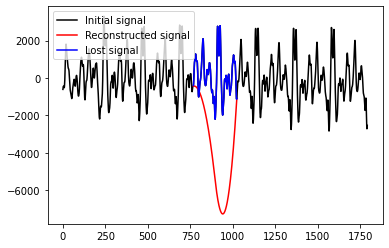

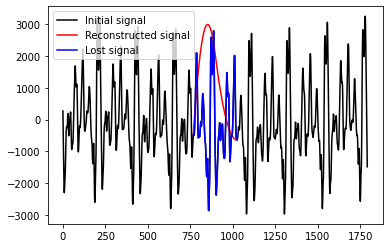

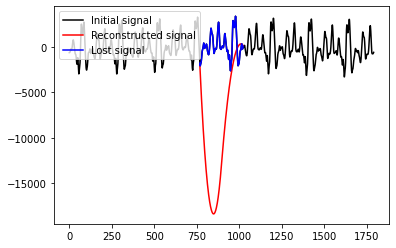

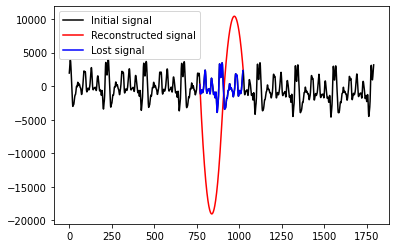

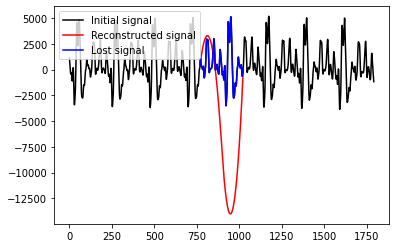

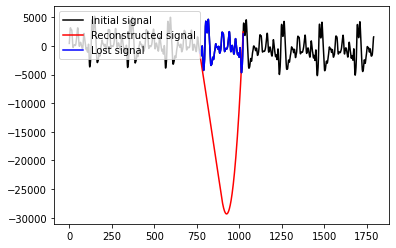

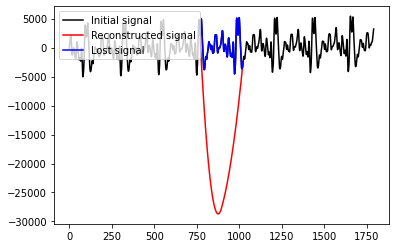

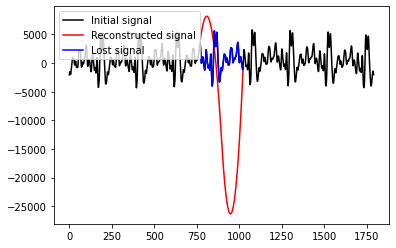

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in short_scalars
  


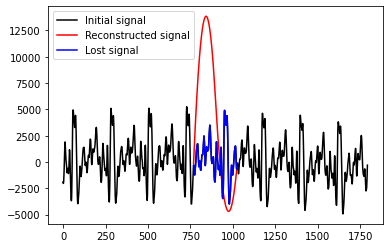

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in short_scalars
  


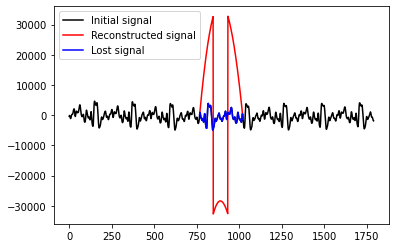

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in short_scalars
  


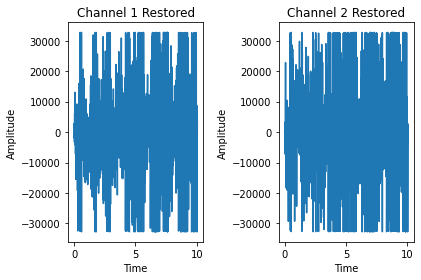

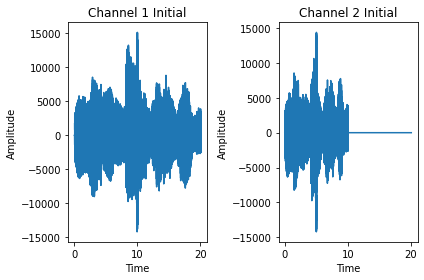

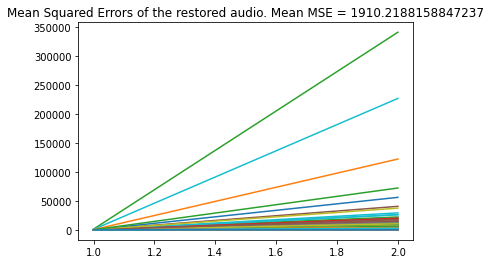

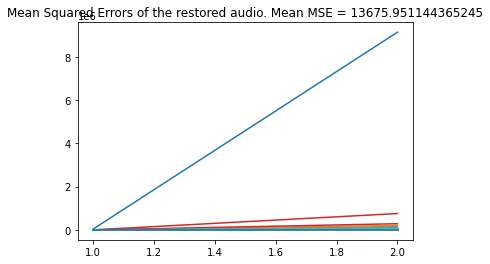

In [ ]:

test_visualize("/content/single_instrument_08__14_24.mp3", 256, "quadratic", 10, 0.25)

In [ ]:
def plot_Burg(loss_percentage, sound_type, our_method, fast_method, standard_method):
  methods_names = ["Burg's method (our implementation)", "Burg's method fast (library)", "Burg's method standard (library)"]
  chunk_sizes = [64, 128, 256]

  fig, (ax1, ax2) = plt.subplots(1, 2)
  # fig.suptitle(f'Loss percentage = {loss_percentage}, Sound = {sound_type}')

  ax1.plot(chunk_sizes, our_method["norm"], color = 'k', label = methods_names[0], marker = 'o')
  ax1.plot(chunk_sizes, fast_method["norm"], color = 'r', label = methods_names[1], marker = 'o')
  ax1.plot(chunk_sizes, standard_method["norm"], color = 'b', label = methods_names[2], marker = 'o')
  ax1.set_title(f"MSE = norm, loss = {loss_percentage}")

  ax2.plot(chunk_sizes, our_method["fft"], color = 'k', label = methods_names[0], marker = 'o')
  ax2.plot(chunk_sizes, fast_method["fft"], color = 'r', label = methods_names[1], marker = 'o')
  ax2.plot(chunk_sizes, standard_method["fft"], color = 'b', label = methods_names[2], marker = 'o')
  ax2.set_title(f"MSE = fft, loss = {loss_percentage}")

  ax2.legend(loc='upper left')
  plt.tight_layout()



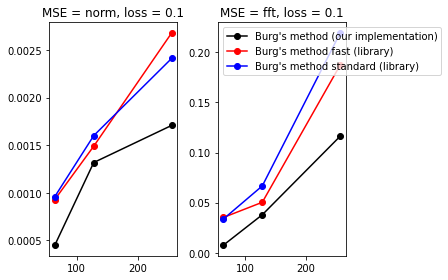

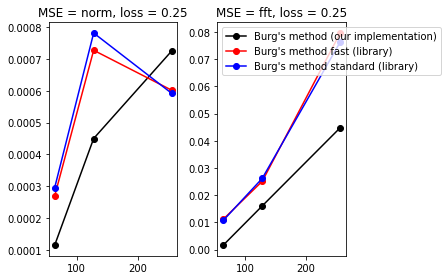

In [ ]:
# Alignment signal
our_method_01 = {"norm": [0.0004493606276, 0.001318088311, 0.001707891132],
                 "fft": [0.007627434178, 0.03796380309, 0.116249668]}
fast_method_01 = {"norm": [0.0009291688518, 0.001489732688, 0.002679186669],
                 "fft": [0.03524130493, 0.05041000657, 0.18720744]}
standard_method_01 = {"norm": [0.0009598300614, 0.001600559844, 0.00241207321],
                 "fft": [0.0336684795, 0.06671326651, 0.2191022345]}

plot_Burg(0.1, "Alignment signal", our_method_01, fast_method_01, standard_method_01)


our_method_025 = {"norm": [0.0001150802199, 0.0004500100037, 0.0007245969406],
                 "fft": [0.001627136167, 0.01604696229, 0.044773032]}
fast_method_025 = {"norm": [0.0002695377547, 0.0007270723785, 0.0006017848191],
                 "fft": [0.011158847, 0.02509362894, 0.07957623556]}
standard_method_025 = {"norm": [0.0002956062557, 0.0007812797878, 0.0005920836125],
                 "fft": [0.0107188982, 0.02615451411, 0.076263441]}

plot_Burg(0.25, "Alignment signal", our_method_025, fast_method_025, standard_method_025)

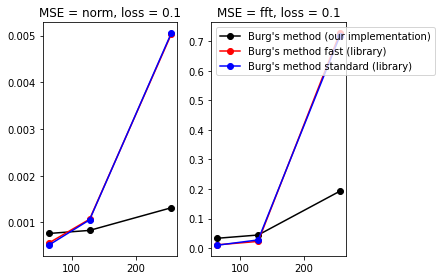

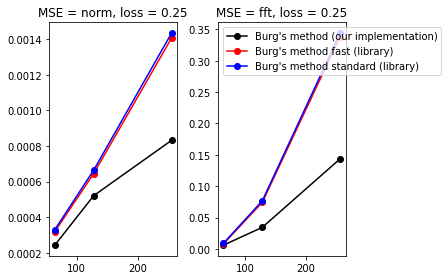

In [ ]:
# Pop music
our_method_01 = {"norm": [0.0007633495412, 0.0008295523997, 0.001314557836],
                 "fft": [0.0332959146, 0.04433236559, 0.1927450431]}
fast_method_01 = {"norm": [0.0005586220656, 0.001069140014, 0.005033027505],
                 "fft": [0.01107156985, 0.02266969629, 0.7280359828]}
standard_method_01 = {"norm": [0.0005128777018, 0.00105514717, 0.005055255739],
                 "fft": [0.009871473682, 0.02769862232, 0.718181686]}
plot_Burg(0.1, "Pop music", our_method_01, fast_method_01, standard_method_01)


our_method_025 = {"norm": [0.0002424359187, 0.0005211059184, 0.0008323030684],
                 "fft": [0.005873253915, 0.03431066062, 0.1436747328]}
fast_method_025 = {"norm": [0.0003185761821, 0.0006455869012, 0.001407874212],
                 "fft": [0.007795895144, 0.07416843514, 0.3384355506]}
standard_method_025 = {"norm": [0.0003293484516, 0.000664775653, 0.001435689063],
                 "fft": [0.008781242706, 0.07666453744, 0.3441474776]}
plot_Burg(0.25, "Pop music", our_method_025, fast_method_025, standard_method_025)

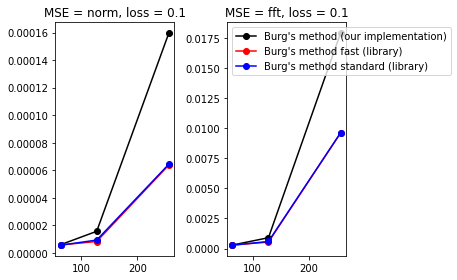

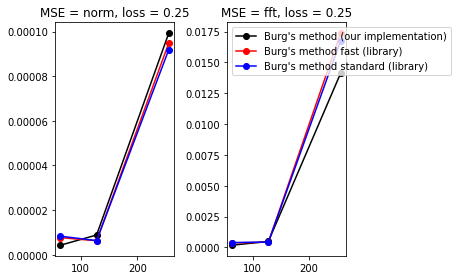

In [ ]:
# Single instrument
our_method_01 = {"norm": [0.00000591880582345921, 0.0000156477676989291, 0.00015973860697393],
                 "fft": [0.0002907312313, 0.000898491239, 0.01791602988]}
fast_method_01 = {"norm": [0.00000573531260484901, 0.00000823464363272884, 0.0000638651990663183],
                 "fft": [0.0002899158518, 0.000537145183, 0.009616678279]}
standard_method_01 = {"norm": [0.00000555539954715753, 0.00000928520621002267, 0.0000644465681366681],
                 "fft": [0.0002777686069, 0.0005852097962, 0.009622367993]}
plot_Burg(0.1, "Single instrument", our_method_01, fast_method_01, standard_method_01)


our_method_025 = {"norm": [0.00000428894504933265, 0.00000886276963210221, 0.0000993686228421656],
                 "fft": [0.0001752979295, 0.0004838033063, 0.01413018425]}
fast_method_025 = {"norm": [0.00000768301082568002, 0.00000625654144415286, 0.0000949217534164552],
                 "fft": [0.000359428696, 0.0004200111621, 0.01739225082]}
standard_method_025 = {"norm": [0.00000831884520316117, 0.00000634909765917818, 0.0000919462957217019],
                 "fft": [0.0003904605795, 0.0004286302664, 0.01676815543]}
plot_Burg(0.25, "Single instrument", our_method_025, fast_method_025, standard_method_025)

In [ ]:
def plot_interpolation(name, chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage):

  fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True)
  # fig.suptitle(f'Audio = {name}, loss = {loss_percentage}')
  axs1.plot(chunk_sizes, linear, color = 'k', marker ='o', label = 'linear')
  axs1.plot(chunk_sizes, quadratic, color = 'g', marker ='o', label = 'quadratic')
  axs1.plot(chunk_sizes, trigonometric, color = 'r', marker ='o', label = 'trigonometric')
  axs1.set_title(f"Normilized MSE")
  # axs1.xaxis.set_label_position('top')
  axs1.set(xlabel='chunk size', ylabel="MSE value")

  axs2.plot(chunk_sizes, lin_fft, color = 'k', marker ='o', label = 'linear')
  axs2.plot(chunk_sizes, quadratic_fft, color = 'g', marker ='o', label = 'quadratic')
  axs2.plot(chunk_sizes, trigonometric_fft, color = 'r', marker ='o', label = 'trigonometric')
  axs2.set_title(f"FFT MSE")
  axs2.set(xlabel='chunk size', ylabel="MSE value")

  plt.legend(loc='upper left')
  plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


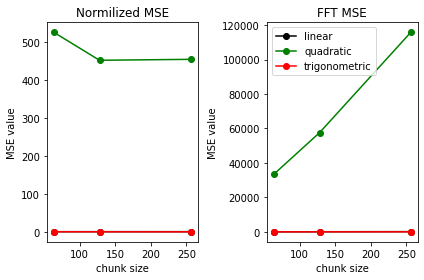

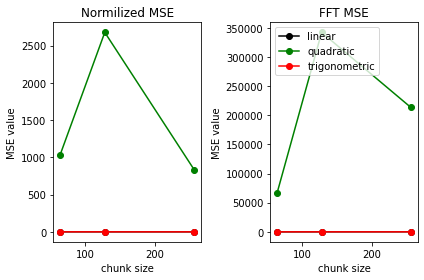

In [ ]:
#Alignment signal

chunk_sizes = [64, 128, 256]
linear = [0.661838381359687, 0.694876309550076, 0.685022761768231]
lin_fft = [25.8877090119844, 60.0759971741339, 124.174492704035]
quadratic = [525.39034870021, 451.949351711052, 454.416805841351]
quadratic_fft = [33480.0967578353, 57556.9265296823, 115758.390118682]
trigonometric = [0.465058450818352, 0.373253600018485, 0.279851495434134]
trigonometric_fft = [7.60813830356853, 10.6741676633511, 17.209667890863]
loss_percentage = 0.1
plot_interpolation("alignment signal", chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage)

linear = [0.67381955653226, 0.700973664436517, 0.684787162230974]
lin_fft = [27.3563806604127,60.6397962375386, 124.724709246708]
quadratic = [1034.1841494023, 2676.24472460256, 835.883875056513]
quadratic_fft = [66038.8682237111, 342160.202234612, 213369.624861228]
trigonometric = [0.4385399536, 0.3652950507, 0.2736977597]
trigonometric_fft = [7.295439037, 11.18198943, 17.06213153]
loss_percentage = 0.25


plot_interpolation("alignment signal", chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


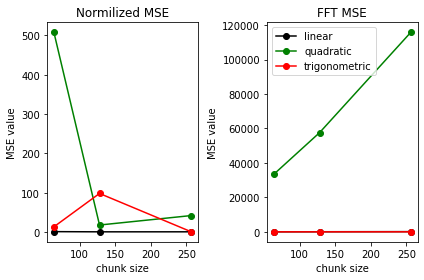

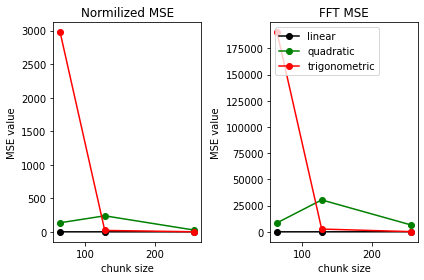

In [ ]:
#pop music

chunk_sizes = [64, 128, 256]


linear = [1.059557975, 0.5588598935, 0.5964445325]
lin_fft = [25.88770901, 60.07599717, 124.1744927]
quadratic = [507.8296583, 17.86281128, 41.7872354]
quadratic_fft = [33480.09676, 57556.92653, 115758.3901]
trigonometric = [13.33300821,98.14284286,1.207509937]
trigonometric_fft = [7.608138304, 10.67416766, 17.20966789]
loss_percentage = 0.1


plot_interpolation("pop music", chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage)




linear = [0.4780706322, 0.5464098637, 0.6583478396]
lin_fft = [15.61693296, 34.5731038, 89.55380897]
quadratic = [135.7105127, 239.3372785, 26.95031872]
quadratic_fft = [8612.267759, 30459.2419, 6617.795629]
trigonometric = [2974.889658, 21.52858247, 1.307920358]
trigonometric_fft = [190302.3692, 2656.011471, 197.0934219]
loss_percentage = 0.25


plot_interpolation("pop music", chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


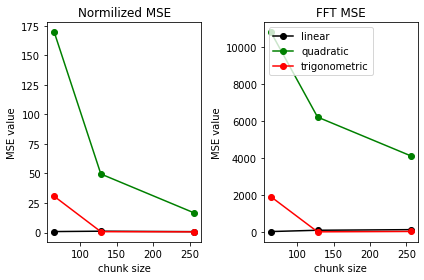

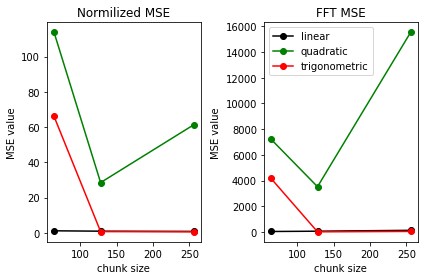

In [ ]:
#single insrument
chunk_sizes = [64, 128, 256]
linear = [0.8166396122, 1.128878825, 0.7481840732]
lin_fft = [29.75768562, 99.33203346, 132.5178609]
quadratic = [169.5008494, 49.58264189, 16.71592252]
quadratic_fft = [10796.23803, 6217.218519, 4125.551029]
trigonometric = [30.6032556, 0.7196289166, 0.5921343322]
trigonometric_fft = [1907.326208, 14.58521379, 34.47474709]
loss_percentage = 0.1


plot_interpolation("single instrument", chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage)


linear = [1.108563959, 0.8926489365, 0.7700630574]
lin_fft = [47.37819586, 70.07921815, 137.9588881]
quadratic = [113.7380887, 28.47312706, 61.27354481]
quadratic_fft = [7223.479084, 3529.29383, 15524.89642]
trigonometric = [65.99561602, 0.6624688631, 0.5277929469]
trigonometric_fft = [4177.494875, 21.14957055, 51.82286609]
loss_percentage = 0.25


plot_interpolation("single instrument", chunk_sizes, linear, lin_fft, quadratic, quadratic_fft, trigonometric, trigonometric_fft, loss_percentage)
